# Introduction


The study of language variation has long been a crucial area of linguistic research, offering valuable insights into the historical, social, and geographical factors that shape language use in society. Linguists have traditionally sought to understand how language varieties—such as dialects—are distributed across different regions and communities. A central question in twentieth-century dialectology concerns the analysis of geographic coherence in language variation: given the imperfect geographic boundaries of dialects, how should this variation be analyzed? Traditionally, dialectology has focused on identifying dialect areas, defined as regions with relatively limited internal linguistic variation, distinguishing them from neighboring areas.

However, the existence of such dialect areas, which we intuitively perceive, has proven difficult to demonstrate rigorously. Kretzschmar (1998) offers a potential explanation, differentiating between attributive dialects—linguistic varieties specific to a given place—and blind dialects, or areas whose distinctiveness cannot easily be captured by conventional methods. Field linguists can often catalog the linguistic features of a particular location, identifying an attributive dialect, but struggle to compare it meaningfully with varieties from other places. This challenge arises because traditional non-computational approaches typically analyze a small number of linguistic features, making it difficult to capture aggregate levels of variation.

Recent advances in computational techniques have transformed this landscape, enabling linguists to study language variation at scale. For example, simple techniques such as counting differences between linguistic features allowed Seguy to aggregate individual differences over large datasets. Other researchers, such as Speelman, Grondelaers, and Geeraerts, have utilized relative frequency analyses to measure variation, exploring how pairs of alternative lexical choices—such as *car* vs. *automobile* or *quiet* vs. *still*—can reveal deeper insights into linguistic differences. These frequency-based approaches, often referred to as linguistic profiles, have become essential tools in quantifying linguistic distance.

Building on these computational approaches, this paper explores the application of Principal Component Analysis (PCA) and clustering techniques for analyzing large-scale linguistic datasets. PCA is employed to reduce the dimensionality of the linguistic variables, capturing the most significant patterns of variation. Clustering methods, such as K-Means and Agglomerative Clustering, are then applied to group linguistic varieties based on their aggregate features. These techniques enable the identification of meaningful linguistic groupings and the exploration of dialect areas at a finer granularity than traditional methods. By incorporating computational tools like PCA and clustering, we hope to address longstanding challenges in dialectology, providing a more robust and scalable framework for analyzing language variation across regions.

# The Data 

The data are from a Dialect Survey conducted by Bert Vaux: https://www.dialectsofenglish.com/. The questions and answers  was found and processed from the http://dialect.redlog.net/index.html by a past intrepid STAT215A student.  The dataset contains the answers to the survey questions for 47, 471 respondents across the United States as well as the variables ID, CITY, STATE, ZIP, Q50 - Q121, lat and long. ID is a number identifying the respondent. CITY and STATE were self reported by respondents. Former GSIs found the latitude and longitude for the center of each zipcode and added the lat and long variables based on the reported city and state. Then the data was binned into one degree latitude by one degree longitude squares. In this paper, we will focus on the questions that
look at lexical differences as opposed to phonetic differences, which are numbered 50-121.

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pyreadr import read_r
import numpy as np

# Load the data
ling_data = pd.read_csv('../data/lingData.txt', sep='\\s+')
ling_location = pd.read_csv('../data/lingLocation.txt', sep='\\s+')

# ling_data has a column for each question, and ling_location has a column
# for each question x answer.  Sorry the columns in ling_location are not usefully named,
# but it's not too tricky to figure out which is which.
# Note that you still need to clean this data (check for NA's, missing location data, etc.)

# Load the question_data which contains quest.mat, quest.use, ans.---
question_data = read_r('../data/question_data.RData')

In [ ]:
# Loop through each column and store the value counts
# List of categorical columns
categorical_cols = ['Q050', 'Q051', 'Q052', 'Q053', 'Q054',
                    'Q055', 'Q056', 'Q057', 'Q058', 'Q059', 'Q060', 'Q061', 'Q062', 'Q063',
                    'Q064', 'Q065', 'Q066', 'Q067', 'Q068', 'Q069', 'Q070', 'Q071', 'Q072',
                    'Q073', 'Q074', 'Q075', 'Q076', 'Q077', 'Q078', 'Q079', 'Q080', 'Q081',
                    'Q082', 'Q083', 'Q084', 'Q085', 'Q086', 'Q087', 'Q088', 'Q089', 'Q090',
                    'Q091', 'Q092', 'Q093', 'Q094', 'Q095', 'Q096', 'Q097', 'Q098', 'Q099',
                    'Q100', 'Q101', 'Q102', 'Q103', 'Q104', 'Q105', 'Q106', 'Q107', 'Q109',
                    'Q110', 'Q111', 'Q115', 'Q117', 'Q118', 'Q119', 'Q120', 'Q121']
# for column in categorical_cols:
#      print(ling_data[column].value_counts(dropna=False))
#      print()


## Data Cleaning

In the dataset, "QXXX" are the responses to the corresponding question on the survey website. A value of 0 indicates no response. The other numbers should directly match the responses on the website, i.e. a value of 1 should match a response of (a). Data cleaning will drop rows with answers to 25 questions or more as "0", which reduced the record from 47471 to 46136. 

In [ ]:
import clean  # Import the clean_data1.py module
# Drop rows with more than 25 missing values in the categorical columns

new_ling_data = clean.drop_rows_zero(ling_data, categorical_cols, 25)
#new_ling_data 
#ling_data.shape, new_ling_data.shape

In [ ]:
# # Inspect column names
# print(ling_data.columns)
# print(ling_location.columns)

# Load state geometries
state_df = gpd.read_file('../data/shapefiles')
state_df = state_df[state_df['iso_a2'] == 'US']  # Filter to only US

In [ ]:
# load .Rdata file
from pyreadr import read_r
question_data = read_r('/Users/lloydconnelly/stat-215-a/lab2/data/question_data.RData')

In [ ]:
# question_data.values()

In [ ]:
# for key, value in question_data.items():
#     print(f"Key: {key}")
#     print("Value:")
#     print(value)
#     print("\n")  


## Exploratory Data Analysis 

We picked two survey questions and investigate their relationship to each other and geography:  what word do you use to refer 'mow the lawn' and what word do you use to refer 'water fountain'? We created interactive maps to examine the geographical relationships.  It seems "mow the lawn" and "cut the grass" are most common for the first question while "water fountain" and "drinking fountain" are most common for the second question. However, the popular answers do not define geopgraphical groups, as they spread across US. However, the infrequent answers ("mow the grass" and "bubbler") seem to have a more distinct clusters (central and south US), consistent with Goebl's observation when he assigned more heavy weightings which count overlap in infrequent words. 


In [ ]:


import plotly.express as px

def plot_interactive_map(df, question_code):
    fig = px.scatter_mapbox(
        df, lat='lat', lon='long', color=question_code,
        zoom=3, mapbox_style='carto-positron',
        title=f"Interactive Map of Responses for {question_code}"
    )
    fig.show()
    
# Plot interactive maps
#plot_interactive_map(grass, 'ans')
#plot_interactive_map(bubbler, 'ans')


![](1.png)


![](2.png)


Next we explore if the answers to the two questions define any distinct geographical groups. Similarly to previous finding, the infrequent pair such as "mow the grass" and "bubbler" seem to form a cluster than the common phrases, based on the interactive map below. 

In [ ]:
# grass

In [ ]:
# bubbler['ans']

In [ ]:
merged_df = pd.merge(grass, bubbler[['ID', 'ans']], on='ID', how='inner')
merged_df['combined_ans'] = merged_df['ans_x'].astype(str) + '/' +merged_df['ans_y'].astype(str)
# merged_df

In [ ]:
# # Create a new column for combined responses
# combined=new_ling_data.copy()
# combined['Combined_Response'] = (
#     grass['ans'].astype(str) + ' / ' + bubbler['ans'].astype(str)
# )


# Plot the combined responses
#plot_interactive_map(merged_df, 'combined_ans')


![](3.png)


We explore if a response to one question help predict the other by creating a contigency table and a heat map below, which confirms each other. The heatmap visualizes the relationship between responses to two different questions, Q100 (water fountain) and Q103 (mow the lawn). On the x-axis, we see the responses to Q103, and on the y-axis, the responses to Q100. The color intensity in the heatmap represents the frequency of respondents choosing each combination of answers for the two questions. The color bar on the right shows the frequency scale, where darker blue represents a higher number of respondents, and lighter shades represent fewer respondents. Darker squares indicate the most common response combinations between Q100 and Q103. "Water fountain" + "mow the lawn" is the most frequent combination, with 17,374 respondents answering these two options. This suggests that many people who use "water fountain" also prefer "mow the lawn." "Drinking fountain" + "mow the lawn" is the second most common combination, with 9,925 respondents, indicates that "drinking fountain" is also often paired with "mow the lawn."

In [ ]:
# Create a contingency table
contingency_table = pd.crosstab(
    bubbler['ans'],
    grass['ans'],
    margins=True
)
print(contingency_table)


ans                 cut the grass   cut the lawn   mow the grass   \
ans                                                                 
bubbler                        320              8             115   
drinking fountain             3189             89            1067   
water bubbler                   26              1               5   
water fountain                5540            163            2079   
All                           9075            261            3266   

ans                 mow the lawn     All  
ans                                       
bubbler                      1098   1541  
drinking fountain            9925  14270  
water bubbler                  71    103  
water fountain              17374  25156  
All                         28468  41070  


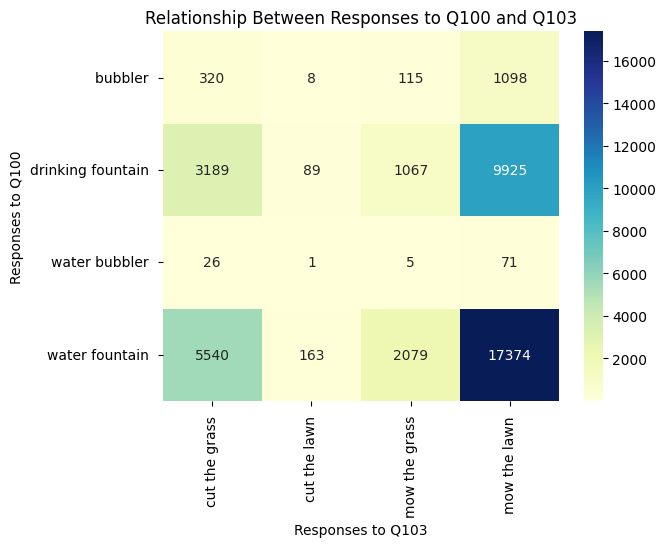

In [ ]:
sns.heatmap(
    contingency_table.iloc[:-1, :-1],
    annot=True, fmt='d', cmap='YlGnBu'
)
plt.title('Relationship Between Responses to Q100 and Q103')
plt.xlabel('Responses to Q103')
plt.ylabel('Responses to Q100')
plt.show()


Quantitatively, we ran chi squared test which showed no significant association found between the responses to the two questions. See output below. 

In [ ]:
from scipy.stats import chi2_contingency

# Prepare the contingency table without margins
contingency = pd.crosstab(
    grass['ans'],
    bubbler['ans']
)

# Perform the chi-squared test
chi2, p, dof, ex = chi2_contingency(contingency)
print(f"Chi-squared Test Statistic: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("There is a significant association between the responses.")
else:
    print("No significant association found between the responses.")


Chi-squared Test Statistic: 12.7872682247342
P-value: 0.17247076692033975
No significant association found between the responses.


# Dimension Reduction

-   This is where you discuss and show plots about the results of
    whatever dimension reduction techniques you tried---PCA, variants of
    PCA, t-SNE, NMF, random projections, etc.

-   What do you learn from your dimension reduction outputs

-   Discuss centering and scaling decisions
It is very likely the two questions are not sufficient as features to characterize aggragate levels as discussed in Nerbonne et. al (2003). We are using all Q50-Q121 to see if that provide enough features. First step is to encode the data so that the response is binary instead of categorical.  This makes p = 541 and n = 46,136. We used k instead of k-1 during the encoding. Next, we used PCA to reduce the dimensions. We started with PCA without scaling and plotted the PC1 and PC2 in 2-D. The dimension reduction didn't seem to maximize the variance of the dataset in PC1 or PC2. Project PC1, PC2 and PC3 to 3-D space and issue persists. 

Feature matrix shape: (46136, 535)


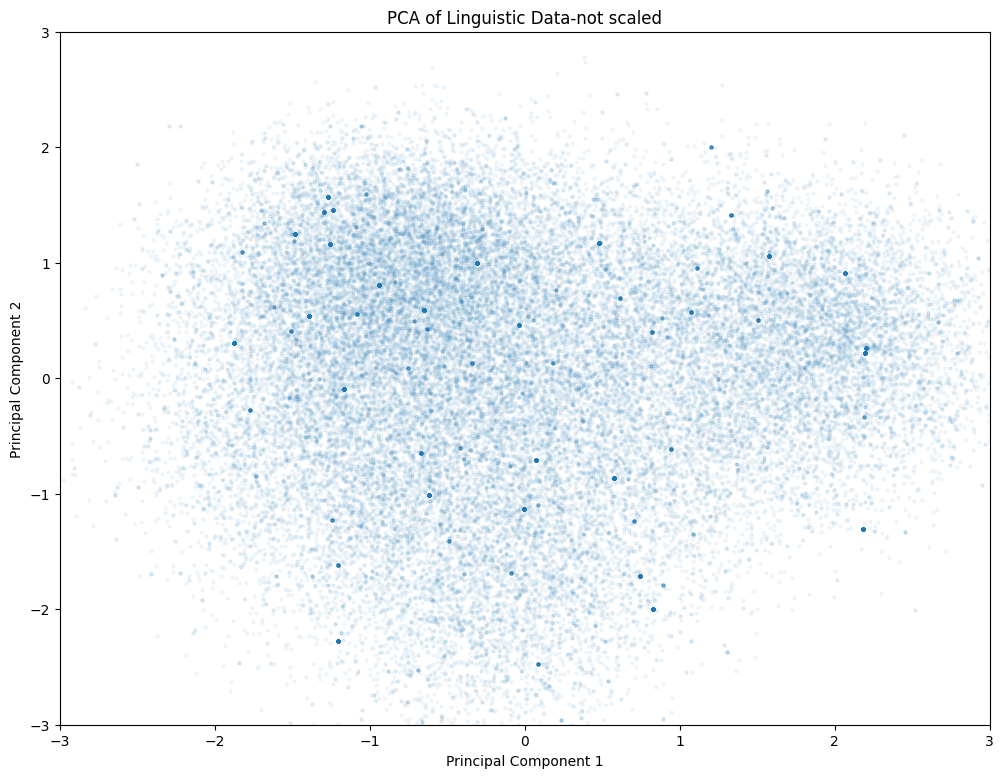

In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA with the desired number of components
pca = PCA(n_components=2)  # For 2D visualization


# Exclude non-feature columns like 'ID', 'lat', 'long', or any other identifiers
non_feature_cols = ['ID', 'lat', 'long']
feature_cols = [col for col in new_ling_data.columns if col not in non_feature_cols and col.startswith('Q')]

# Create feature matrix X
X = new_ling_data[feature_cols].copy()

# Check the shape of X
print(f"Feature matrix shape: {X.shape}")

# Fit PCA to the data
principal_components = pca.fit_transform(X)

# Create a DataFrame for the principal components
pc_df_nonscale = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Combine with non-feature columns if needed
pca_result_nonscale = pd.concat([new_ling_data[non_feature_cols].reset_index(drop=True), pc_df_nonscale], axis=1)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.scatter(pc_df_nonscale['PC1'], pc_df_nonscale['PC2'], alpha=0.05, s=5)  
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Linguistic Data-not scaled')
plt.xlim(-3, 3)  
plt.ylim(-3, 3)
plt.show()



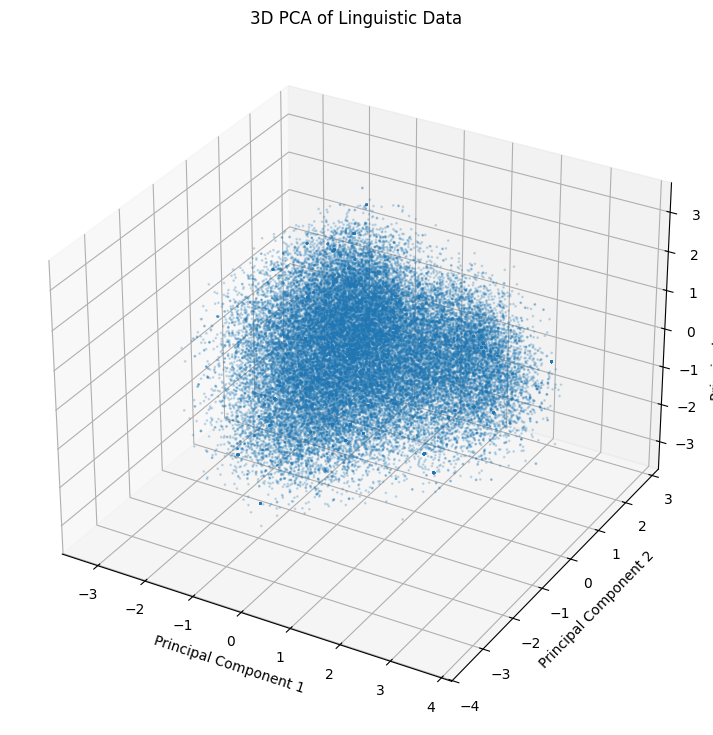

In [ ]:

from mpl_toolkits.mplot3d import Axes3D

# Initialize PCA with 3 components for 3D visualization
pca = PCA(n_components=3)

# Fit PCA to the data
principal_components = pca.fit_transform(X)

# Create a DataFrame for the 3 principal components
pc_df_3D = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

# Plot the 3D PCA result
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
ax.scatter(pc_df_3D['PC1'], pc_df_3D['PC2'], pc_df_3D['PC3'], alpha=0.2, s=1)

# Labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D PCA of Linguistic Data')

# Show the plot
plt.show()


Next, we scaled the encoded dataset, ran PCA and projected the results to 2-D as shown below. The outcome has been significantly improved. Centering ensures that the principal components are computed based on the direction of maximum variance from the mean of the data. Scaling (standardizing to unit variance) is especially important if our features have different units or ranges. Without scaling, features with larger ranges could dominate the PCA, which may lead to incorrect results. However, in our case, scaling helped with our encoded dataset. 

Feature matrix shape: (46136, 535)


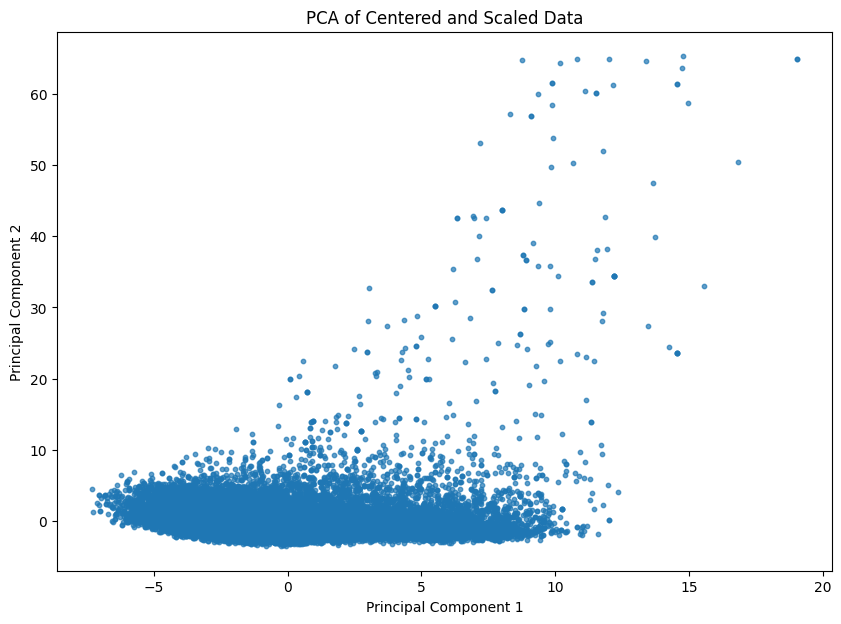

In [ ]:

from sklearn.preprocessing import StandardScaler


# Center and scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# Initialize PCA with the desired number of components
pca = PCA(n_components=2)  

# Fit PCA to the scaled data
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame for the principal components
pc_df_scale = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Combine with non-feature columns if needed
pca_result_scale = pd.concat([new_ling_data[non_feature_cols].reset_index(drop=True), pc_df_scale], axis=1)

# Check the shape of the data
print(f"Feature matrix shape: {X_scaled.shape}")
# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(pca_result_scale['PC1'], pca_result_scale['PC2'], alpha=0.7, s=10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Centered and Scaled Data')
plt.show()

T-SNE was also experimented as a dimension reduction technique, with the encoded and scaled dataset. The dataset was projected onto the primary component and secondary component space as shown below. PCA with scaled data performs better than T-SNE in our case. 

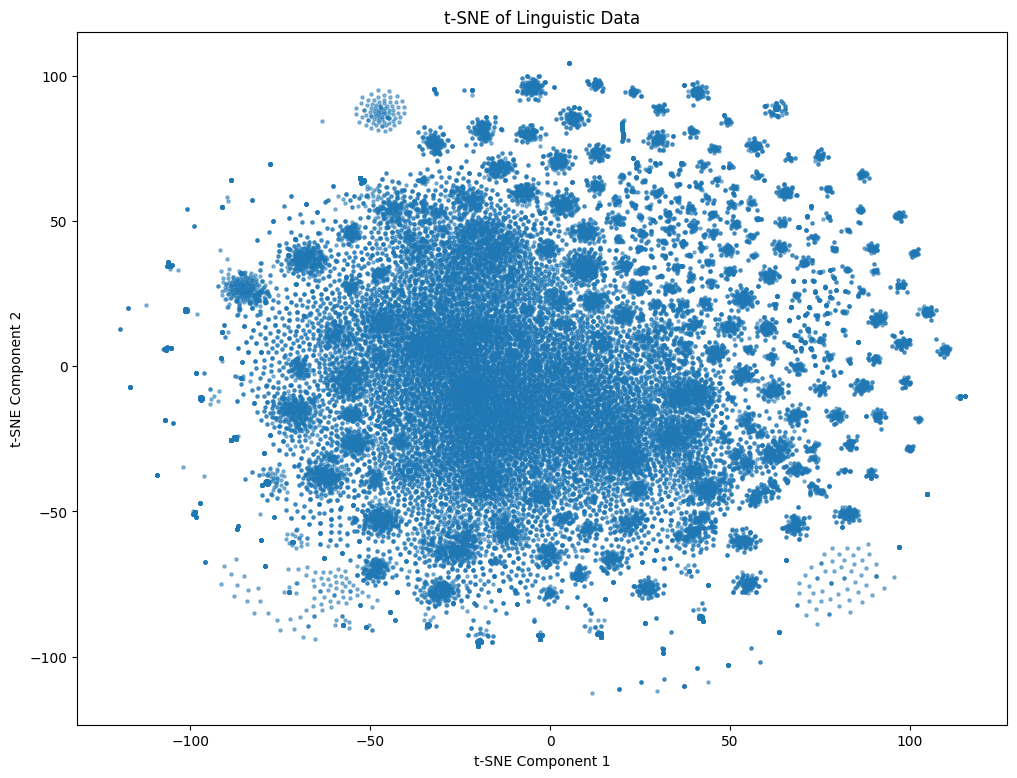

In [ ]:
from sklearn.manifold import TSNE

# Initialize t-SNE with 2 components
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

# Fit t-SNE to the data
tsne_components = tsne.fit_transform(X_scaled)

# Create a DataFrame for the t-SNE components
tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2'])

# Plot the t-SNE components
plt.figure(figsize=(12, 9))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], alpha=0.5, s=5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Linguistic Data')
plt.show()


# Clustering

After the dataset being projected on to PC1 and PC2 after PCA with scaled data, two different clustering methods are performed- K-means and Agglomerative Clustering. K=4 was selected using adjusted_rand_score as an evaluation mechanism, discussed in the Stability section. K-Means Clustering on PCA Projection is shownn below. 


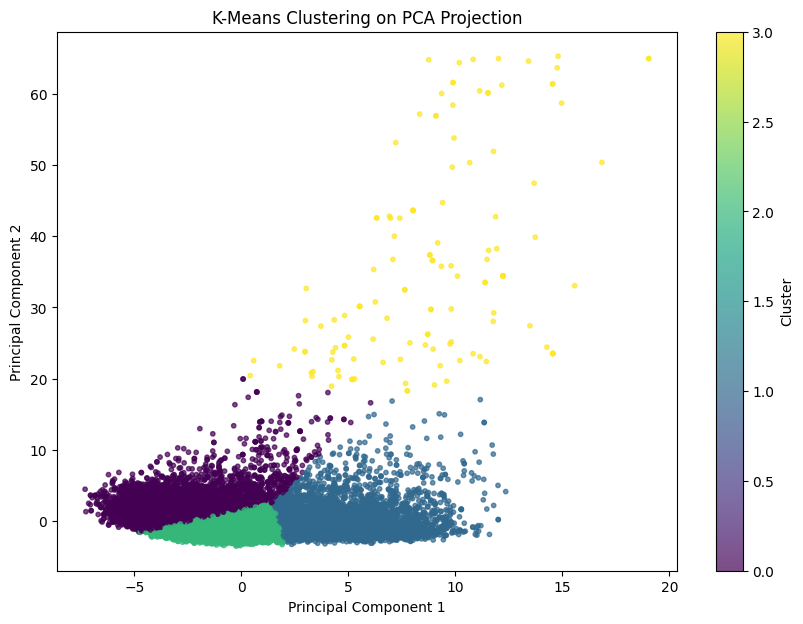

In [ ]:
from sklearn.cluster import KMeans



# Perform K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)  
kmeans_labels = kmeans.fit_predict(pc_df_scale)
# Get the PCA loadings (components)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=feature_cols)

# Add cluster labels to the PCA DataFrame
pc_df_scale['KMeans_Cluster'] = kmeans_labels

# Plot K-Means Clustering results on the PCA projection
plt.figure(figsize=(10, 7))
plt.scatter(pc_df_scale['PC1'], pc_df_scale['PC2'], c=pc_df_scale['KMeans_Cluster'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering on PCA Projection')
plt.show()


In [ ]:
# print(pc_df_scale['KMeans_Cluster'].value_counts())
# pca_result_scale['KMeans_Cluster'] = pc_df_scale['KMeans_Cluster']
# pca_result_scale

We then added the K-means labels to the dataset and plot them on the interactive map below. Consistent with the previous discussion on "mow and lawn" and "water fountain", the common label is widely spread across US while the blue and purple cluster seem to cluster in central/south US and east US. However, we cannot say the blue and purple clusters are completely isolated in a certain geographic area. There seems to be a continuum with a transition in density at central US. 

In [ ]:

# Plot interactive maps
#plot_interactive_map(pca_result_scale, 'KMeans_Cluster')


![](4.png)


We evaluated Which questions produce this continuum or separate the clusters by examing the PCA loading below, in descending order of the absolute value of PC1 weight. The top two weights are assigned to the answers to question 73, as shown below. Question 73 is about the word for "sneakers" or "tennis shoes". 

In [ ]:


# Display the loadings
# print(loadings)
# Sort by absolute values of PC1 loadings
sorted_loadings_abs_PC1 = loadings.reindex(loadings['PC1'].abs().sort_values(ascending=False).index)

# Display the top loadings based on absolute values of PC1
print(sorted_loadings_abs_PC1.head(10))  


             PC1       PC2
Q073_1  0.209652 -0.030818
Q073_6 -0.189739  0.033216
Q105_1  0.148928 -0.057069
Q080_1  0.147106 -0.020493
Q084_1  0.137032 -0.030482
Q093_2 -0.132329  0.001311
Q086_1  0.130709 -0.012003
Q066_5 -0.123389  0.026494
Q106_7  0.121860  0.002081
Q083_1  0.121532 -0.010367


In [ ]:

# 0     73       a  45.50                         sneakers 
# 1     73       b   1.93                            shoes 
# 2     73       c   5.55                         gymshoes 
# 3     73       d   0.03                       sand shoes 
# 4     73       e   0.01                          jumpers 
# 5     73       f  41.34                     tennis shoes 
# 6     73       g   1.42                    running shoes 
# 7     73       h   0.17                          runners 
# 8     73       i   0.23                         trainers 
# 9     73       j   0.89  I have no general word for this 
# 10    73       k   2.95                            other 

Agglomerative Clustering is also examed, as shown below. Agglomerative Clustering is a type of hierarchical clustering where clusters are formed by recursively merging smaller clusters. It starts with each data point as its own cluster and iteratively merges the closest clusters until all points are in one large cluster, or a predefined number of clusters is reached. This "bottom-up" approach contrasts with divisive clustering, which starts with all data points in a single cluster and splits them recursively. Agglomerative Clustering builds a hierarchy of clusters, and the results can be represented using a dendrogram—a tree-like diagram that shows the merging process. It is very computational expense compared to K-means clustering. 


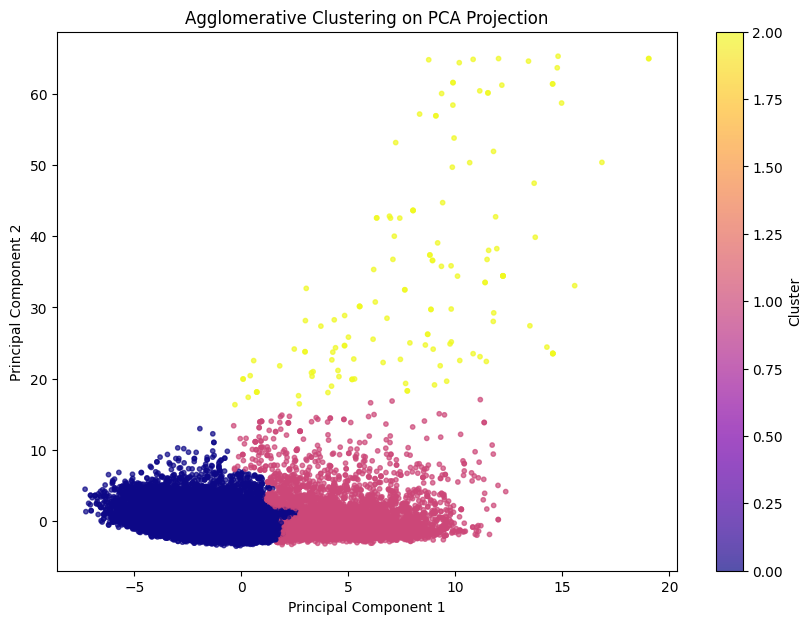

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=3)  
agg_labels = agg_cluster.fit_predict(pc_df_scale)

# Add cluster labels to the PCA DataFrame
pc_df_scale['Agg_Cluster'] = agg_labels

# Plot Agglomerative Clustering results on the PCA projection
plt.figure(figsize=(10, 7))
plt.scatter(pc_df_scale['PC1'], pc_df_scale['PC2'], c=pc_df_scale['Agg_Cluster'], cmap='plasma', s=10, alpha=0.7)
plt.colorbar(label='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Agglomerative Clustering on PCA Projection')
plt.show()


In [ ]:
# pc_df_scale

,PC1,PC2,KMeans_Cluster
0,-0.861760,3.715114,0
1,5.163210,2.005029,1
2,4.562783,0.724209,1
3,4.446937,2.496730,1
4,4.212887,3.322333,1
...,...,...,...
46131,-1.778819,-0.378576,2
46132,-1.324144,0.055743,2
46133,-0.764036,-1.132271,2
46134,-0.695840,-1.154920,2


# Stability of findings to perturbation

We analyzed the robustness of the clusters by bootstrap samping and evaluated the Adjusted Rand Index. After K-means clustering assigned the label for the original dataset and the bootstraped sample dataset, the labels for the same records are compared for consistency. The adjusted Rand Index approaching 1 means the results are consistent and the model is stable. We also used ARI to optimize k, the number of clusters. For k=2, 3 and 5,  ARI is about 0.4; for k=4, using different starting point, ARI is consistenly between 0.96 and 0.98, see one instant below. Therefore we used k = 4 and the model is regarded as stable. 


In [ ]:
from sklearn.metrics import adjusted_rand_score

# Create the original PC1, PC2 DataFrame
pc_df_bootstrap = pc_df_scale[['PC1', 'PC2']]

# Get the cluster labels for the original dataset
kmeans = KMeans(n_clusters=4, random_state=42)
original_labels = kmeans.fit_predict(pc_df_bootstrap)

# Generate a bootstrapped sample, keeping track of the indices
bootstrapped_indices = np.random.choice(pc_df_bootstrap.shape[0], pc_df_bootstrap.shape[0], replace=True)
bootstrap_sample = pc_df_bootstrap.iloc[bootstrapped_indices]

# Get the cluster labels for the bootstrapped sample
bootstrap_labels = kmeans.fit_predict(bootstrap_sample)

# Subset the original_labels to match the bootstrapped sample (based on indices)
original_labels_subset = original_labels[bootstrapped_indices]

# Calculate ARI between the subset of original labels and the bootstrapped labels
ari_score = adjusted_rand_score(original_labels_subset, bootstrap_labels)
print(f"Adjusted Rand Index: {ari_score}")


Adjusted Rand Index: 0.9658040528630559


# Conclusion

Using PCA as a dimension reduction technique and performing k-means clustering has derived some insights on using word choices to identify the geopgraphic regions where the respondents are located. However, common language associates with a shared culture and heritage which might not shared by people clustering physically, because people in US move frequently. Because of this limitation among others, I am not confident that we can use this model to predict the future data. If we have the opportunity to collect the data from the survey, I wonder if we can think of labels to identify the culture and social clusters for respondents to choose from, instead of using their physical location as a proxy. 

As far as reality check, the challenges with PCA is that the new projections are hard to explain intuitively. However, the questions about "water foundation" and "mow the lawn" identified the frequent and infreqent choices of words, which seems to align with the reality. "Sneakers" vs "tennis shoes" also seems to be used by people from distinct regions. 


# Academic Honesty 

## Statement

I affirm that the work presented in this report is my own, and I have not received unauthorized assistance from any individual or source. All external references and sources used have been appropriately cited and acknowledged, and I have followed the guidelines set forth by Prof. Yu regarding academic integrity and honesty. I understand that any violation of these principles may result in disciplinary action.

## LLM Usage


## Collaborators




# Bibliography

[1] John Nerbonne and William Kretzschmar. “Introducing computational techniques in dialectometry”.
In: Computers and the Humanities 37 (2003), pp. 245–255.

[2] John Nerbonne and William Kretzschmar. “Progress in dialectometry: toward explanation”. In: Literary
and Linguistic Computing 21.4 (2006), pp. 387–397.